In [1]:
import re
import pickle
import numpy as np
import pandas as pd
import time
import os
from math import floor
from html import unescape

# nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install kaggle

In [3]:
# copy your kaggle.json to home (kaggle api private key: https://www.kaggle.com/docs/api#authentication)
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle -h

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        config {view, set, unset}
    competitions (c)    Commands related to Kaggle competitions
    datasets (d)        Commands related to Kaggle datasets
    kernels (k)         Commands related to Kaggle kernels
    config              Configuration settings


In [4]:
# Install kaggle-api and set credentials: https://github.com/Kaggle/kaggle-api
# Download 'Sentiment140' dataset with 1.6 million tweets from Kaggle
# https://www.kaggle.com/kazanova/sentiment140?select=training.1600000.processed.noemoticon.csv

!kaggle datasets download kazanova/sentiment140 --force
!unzip -o sentiment140.zip
!rm sentiment140.zip
!mv training.1600000.processed.noemoticon.csv data/

 96%|████████████████████████████████████▋ | 78.0M/80.9M [00:02<00:00, 39.7MB/s]
100%|██████████████████████████████████████| 80.9M/80.9M [00:02<00:00, 33.6MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [5]:
english_stop_words = set(stopwords.words('english'))

# Create Lemmatizer and Stemmer.
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [6]:
#Variables
percentage_of_dataset = 10
test_size = 0.3

In [8]:
DATASET_FILE = 'data/training.1600000.processed.noemoticon.csv'
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv(DATASET_FILE, encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [9]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replacing the values to ease understanding 0:Negative | 1:Positive.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

#Shufle Dataset
origin_dataset = dataset.sample(frac=1)

In [10]:
def reduce_dataset(data,size):
    dataset_to_return = pd.DataFrame(columns=['sentiment', 'text'])
    dataset_len = len(data)+1
    print(f'dataset_len: {dataset_len}')
    quantity_of_each = floor(dataset_len*(size/2)/100)
    print(f'quantity_of_each: {quantity_of_each}')
    print(f'quantity Of reduced Dataset: {quantity_of_each*2}')
    
    def sampling_k_elements(group, k=quantity_of_each):
        if len(group) < k:
            return group
        return group.sample(k)

    dataset_to_return = data.groupby('sentiment').apply(sampling_k_elements).reset_index(drop=True)
    print(dataset_to_return)
    
    return dataset_to_return

In [11]:
dataset = reduce_dataset(origin_dataset, percentage_of_dataset)

dataset_len: 1600001
quantity_of_each: 80000
quantity Of reduced Dataset: 160000
        sentiment                                               text
0               0  what lovely rainy, grey cold weather we have t...
1               0  might go to the pool... except my back hurts. ...
2               0  @SamNiley11 WHAAAAAT? I HATE ALOHA FROM HELL! ...
3               0                                I just got dumped. 
4               0                    @drownatlantis  don't say that!
...           ...                                                ...
159995          1  New iPhone ? http://tinyurl.com/mf8z6f Looks l...
159996          1  @mileycyrus http://twitpic.com/5r808 - wooowww...
159997          1  @cocolee117 do u have more info on the concert...
159998          1  @epeloke That would be, in the words of someon...
159999          1   Don't forget to vote on me.  http://bit.ly/fkQFx

[160000 rows x 2 columns]


            text
sentiment       
0          80000
1          80000


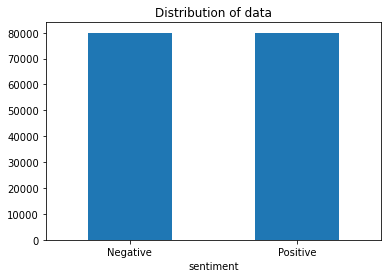

In [12]:
# Plotting the distribution for dataset.
print(dataset.groupby('sentiment').count())
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [13]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat', 
          '&lt;3': 'heart', '<3': 'heart'}

"""
textdata: [string] => collection of sentences to be preprocessed
sentiments: [string] => collection of positives/negatives
mode: string => parameter to indicate mode of converting data (L=lemmatized | S=stemmed text | N=None)
"""
def preprocess(textdata, sentiments, mode, remove_stopwords = False):
    processed_text = []
    
    # Defining regex patterns.
    url_pattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user_pattern       = '@[^\s]+'
    alpha_pattern      = "[^a-zA-Z0-9]"
    sequence_pattern   = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"
    
    for i in range(len(textdata)):
        tweet = textdata[i]
        #Lower casing
        tweet = tweet.lower()
        
        # Remove all URls 
        tweet = re.sub(url_pattern,'',tweet)
        
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, " EMOJI" + emojis[emoji])
            
        # Replace @USERNAME to ' '.
        tweet = re.sub(user_pattern,' ', tweet)
        
        # Remove word &quot; &amp; &gt; &lt; and others
        tweet = unescape(tweet)
        
        # Replace all non alphabets.
        tweet = re.sub(alpha_pattern, " ", tweet)

        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequence_pattern, seq_replace_pattern, tweet)  

        word_tokens = word_tokenize(tweet)

        #Removing english stopwords.
        if remove_stopwords == True:
            filtered_sentence = [w for w in word_tokens if not w in english_stop_words]
        else:
            filtered_sentence = [w for w in word_tokens]
            
        if mode == 'L':
            #Lemmatization
            final_sentence = [lemmatizer.lemmatize(w) for w in filtered_sentence]
        elif mode == 'S':
            #Stemming
            final_sentence = [ps.stem(w) for w in filtered_sentence]
        else:
            #None
            final_sentence = filtered_sentence
            
        sentence = ' '.join(final_sentence)
            
        if len(filtered_sentence) == 0:
            newSample = origin_dataset[origin_dataset.sentiment == sentiments[i]].sample(1)
            newSampleList = list(newSample['text'])
            sentence = preprocess(newSampleList, sentiments, mode)[0]
            
        processed_text.append(sentence)
        
    return processed_text

In [14]:
#Preprocess method
t = time.time()
processed_text = preprocess(text, sentiment, 'N', False)
print(f'Text Preprocessing complete. Time Taken: {round(time.time()-t)} seconds')
#Replace processed_text in dataset
dataset['text'] = processed_text
dataset

Text Preprocessing complete. Time Taken: 65 seconds


,sentiment,text
0,0,what lovely rainy grey cold weather we have today
1,0,might go to the pool except my back hurts coul...
2,0,whaat i hate aloha from hell i want mitchel EM...
3,0,i just got dumped
4,0,don t say that
...,...,...
159995,1,new iphone looks like a lot to the current iph...
159996,1,wooww you are so cutee i love you and
159997,1,do u have more info on the concert in la is it...
159998,1,that would be in the words of someone hot espe...


            text
sentiment       
0          80000
1          80000


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

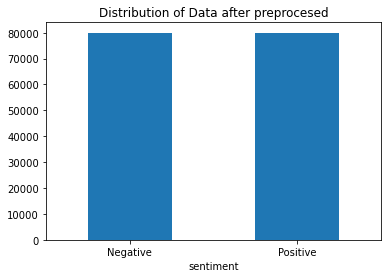

In [15]:
# Plotting the distribution for dataset.
print(dataset.groupby('sentiment').count())
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of Data after preprocesed',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [16]:
#Split Dataset
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['sentiment'], test_size = test_size, stratify=dataset['sentiment'], shuffle=True)
test_dataset = pd.DataFrame({'sentiment': y_test, 'text': X_test})
train_dataset = pd.DataFrame({'sentiment': y_train, 'text': X_train})

            text
sentiment       
0          56000
1          56000


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

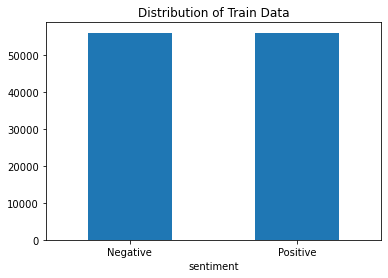

In [17]:
# Plotting the distribution for dataset.
print(train_dataset.groupby('sentiment').count())
ax = train_dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of Train Data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

            text
sentiment       
0          24000
1          24000


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

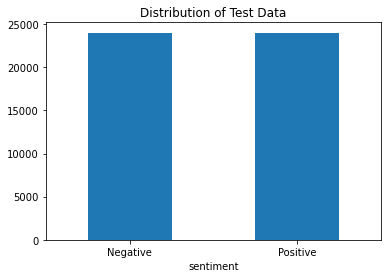

In [18]:
# Plotting the distribution for dataset.
print(test_dataset.groupby('sentiment').count())
ax = test_dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of Test Data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [19]:
#Save the csv only with sentiment and text columns
train_dataset.to_csv('data/preprocessed/sentiments-preprocessed-wo-lemmatizing-with-stopwords-train-10percent-dataset.csv', index=False, header=False)
test_dataset.to_csv('data/preprocessed/sentiments-preprocessed-wo-lemmatizing-with-stopwords-test-10percent-dataset.csv', index=False, header=False)

In [28]:
#Preprocess again with Lemmatizing only
t = time.time()
processed_text = preprocess(text, sentiment, 'L', True)
print(f'Text Preprocessing complete. Time Taken: {round(time.time()-t)} seconds')
#Replace processed_text in dataset
dataset['text'] = processed_text
dataset

#Save the csv only with sentiment and text columns
train_dataset.to_csv('data/preprocessed/sentiments-preprocessed-lemmatizing-train-10percent-dataset.csv', index=False, header=False)
test_dataset.to_csv('data/preprocessed/sentiments-preprocessed-lemmatizing-test-10percent-dataset.csv', index=False, header=False)

Text Preprocessing complete. Time Taken: 118 seconds


In [20]:
import sagemaker
sagemaker_session = sagemaker.Session()

# Save to a common S3 bucket
# Uou'll need the S3 bucket ARN later (copy it!)
sagemaker_session.upload_data(
    path=os.path.join('data','preprocessed'),
    key_prefix='preprocessed')

's3://sagemaker-sa-east-1-343618571470/preprocessed'